### <span style="color:orange"><center>泰坦尼克号之幸存预测</center ><span>

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from pylab import mpl
import sklearn as sk

import datetime
import time
import os
import seaborn as sns

%matplotlib inline

#### 显示中文标签，负号

In [2]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
data_train = pd.read_csv('train.csv')

### <span style="color:orange">Data Exploration<span>
#### 数据观察在数据分析中是非常重要的，为后续决策提供思路：数据有哪些特征？哪些数据需要清洗？

In [4]:
data_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


* 从数据可以看出Age, Cabin存在空值

* 这就是典型的dataframe格式，总共有12列，其中Survived字段表示的是该乘客是否获救，其余都是乘客的个人信息，包括：  

    * PassengerId =>> 乘客ID  
    * Survived =>> 0为未获救，1为获救  
    * Pclass =>> 乘客等级(1/2/3等舱位)  
    * Name =>> 乘客姓名  
    * Sex =>> 性别  
    * Age =>> 年龄  
    * SibSp =>> 堂兄弟/妹个数  
    * Parch =>> 父母与小孩个数  
    * Ticket =>> 船票信息  
    * Fare =>> 票价  
    * Cabin =>> 客舱  
    * Embarked =>> 登船港口  

In [5]:
data_train.shape

(891, 12)

#### 我们再来看一下空值都有多少

In [6]:
print('data_train ({} rows) null_value:\n'.format(data_train.shape[0]))
print(data_train.isnull().sum(axis=0))

data_train (891 rows) null_value:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


* 就像刚才猜测的Age, Cabin有比较多的空值，Embarked也有一定的空值。这些空值最后要怎么处理，是替换还是直接删除呢？

#### 看一下各feature的数据类型

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### 再用describe()查看数值型数据的分布

In [8]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 我们从上面看到更进一步的什么信息呢？  

  mean字段告诉我们，约39%的人最后获救了，2.30说明2/3等舱的人数比1等舱要多，平均乘客年龄大概是29.7岁(计算这个时候会略掉空值)等等

#### 看一下Categorical features的分类统计情况如何？

In [9]:
data_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [10]:
data_train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

* 共有342人获救

In [11]:
data_train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

* 三等舱人数最多，头等舱次之，二等舱人数最少。

In [12]:
data_train.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [13]:
data_train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [14]:
data_train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [15]:
data_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

#### <span style="color:blue">数据探索性分析<span>
#### 画图来看看属性和结果之间的关系

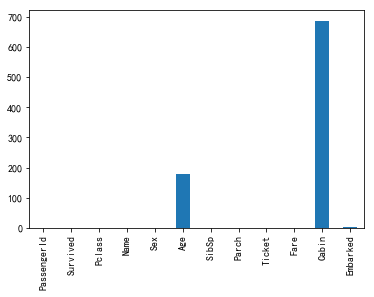

In [16]:
data_train.isnull().sum().plot(kind='bar')

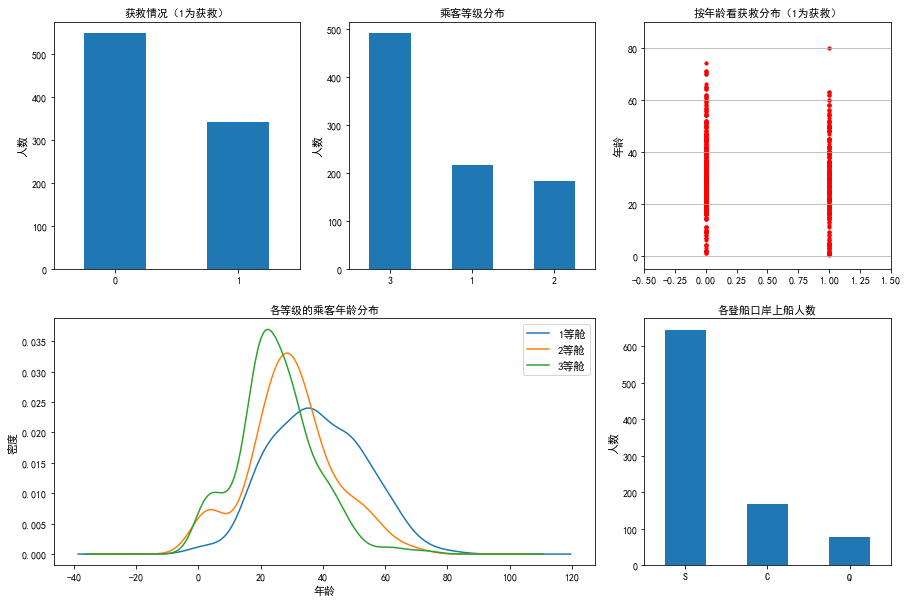

In [17]:
fig = plt.figure(figsize=(15,10))
fig.set(alpha=0.2)

plt.subplot2grid((2,3),(0,0))

data_train.Survived.value_counts().plot(kind="bar")
plt.title("获救情况（1为获救）", fontsize=11)
plt.ylabel("人数", fontsize=11)
plt.xticks(rotation=360)

plt.subplot2grid((2,3),(0,1))
data_train.Pclass.value_counts().plot(kind="bar")
plt.title("乘客等级分布", fontsize=11)
plt.ylabel("人数", fontsize=11)
plt.xticks(rotation=360)

plt.subplot2grid((2,3),(0,2))
plt.scatter(data_train.Survived, data_train.Age, color='r', s=10)                             
plt.grid(b=True, which='major', axis='y')
plt.title("按年龄看获救分布（1为获救）", fontsize=11)
plt.ylabel("年龄", fontsize=11)
plt.axis([-0.5, 1.5, -5, 90])

plt.subplot2grid((2,3),(1,0),colspan=2)        #两列合并
data_train.Age[data_train.Pclass == 1].plot(kind='kde')
data_train.Age[data_train.Pclass == 2].plot(kind='kde')
data_train.Age[data_train.Pclass == 3].plot(kind='kde')
plt.title("各等级的乘客年龄分布", fontsize=11)
plt.xlabel("年龄", fontsize=11)
plt.ylabel("密度", fontsize=11)
plt.legend(("1等舱", '2等舱', '3等舱'),loc='best', fontsize=11)

plt.subplot2grid((2,3),(1,2))
data_train.Embarked.value_counts().plot(kind='bar')
plt.title("各登船口岸上船人数", fontsize=11)
plt.ylabel("人数", fontsize=11)
plt.xticks(rotation=360)

plt.show()

* 从图可知，被救的人342个，不到总人数的一半；三等舱乘客最多；  
  遇难和获救的人年龄似乎跨度都很广；  
  3个不同客舱的年龄总体趋势也较为一致，二等舱/三等舱乘客20~30岁的人最多，头等舱40岁左右的最多，这也符合财富和年龄的分配；  
  登船港口人数按照S、C、Q递减，而且S远多于另外俩港口。


* 到这一步我们可能会有一些想法了：  
  不同舱位/乘客等级和财富/地位有关系，最后获救概率可能会不一样；  
  年龄对获救概率也一定是有影响的，毕竟副船长说了『小孩和女士先走』；  
  和登船港口有没有关系呢？也许登船港口不同，人的出身地位不同。  

#### <span style="color:blue">各属性与获救结果的关联统计<span>

#### <span style="color:green">Pclass与获救结果的关系<span>

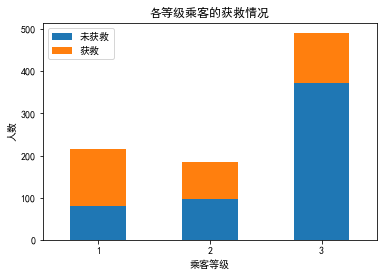

In [18]:
fig = plt.figure(figsize=(10,5))
fig.set(alpha=0.2)

Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()

df = pd.DataFrame({'获救':Survived_1, '未获救':Survived_0})

df.plot(kind='bar', stacked=True)       #条形图堆叠
plt.title("各等级乘客的获救情况")
plt.xlabel("乘客等级")
plt.ylabel("人数")
plt.xticks(rotation=360)

plt.show()

In [19]:
data_train.pivot_table(values='PassengerId',index='Survived',columns='Pclass',aggfunc='count')

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


* 头等舱幸存率：62%  
  二等舱幸存率：47%  
  三等舱幸存率：24%  

* 生死面前并非人人平等。  
 “要等头等舱的先上救生船，我们才能上。”被船员关在甲板下的妈妈安抚着天真幼小的女儿。  
  来自不同社会背景的各色人等，在面对死亡时所面临的选择和遭遇各自不同。

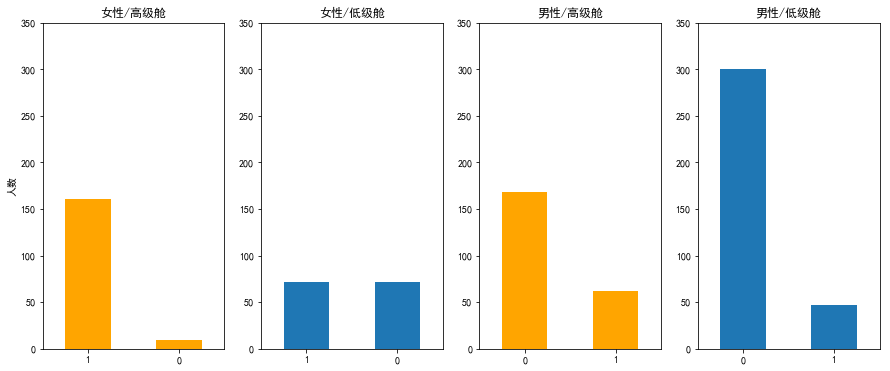

In [20]:
fig = plt.figure(figsize=(15,6))

plt.subplot2grid((1,4),(0,0))
ds1 = data_train.Survived[data_train.Sex == 'female'][data_train.Pclass != 3].value_counts()
ds1.plot(kind="bar", color='orange')
plt.title("女性/高级舱")
plt.ylabel("人数")
plt.xticks(rotation=360)
plt.axis([-0.5,1.5,0, 350])   

plt.subplot2grid((1,4),(0,1))
ds2 = data_train.Survived[data_train.Sex == 'female'][data_train.Pclass == 3].value_counts()
ds2.plot(kind="bar")
plt.title("女性/低级舱")
plt.xticks(rotation=360)
plt.axis([-0.5,1.5,0, 350]) 

plt.subplot2grid((1,4),(0,2))
ds3 = data_train.Survived[data_train.Sex == 'male'][data_train.Pclass != 3].value_counts()
ds3.plot(kind="bar", color='orange')
plt.title("男性/高级舱")
plt.xticks(rotation=360)
plt.axis([-0.5,1.5,0, 350]) 

plt.subplot2grid((1,4),(0,3))
ds4 = data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 3].value_counts()
ds4.plot(kind="bar")
plt.title("男性/低级舱")
plt.xticks(rotation=360)
plt.axis([-0.5,1.5,0, 350]) 


plt.show()

#### <span style="color:green">性别(Sex)与获救结果的关系<span>

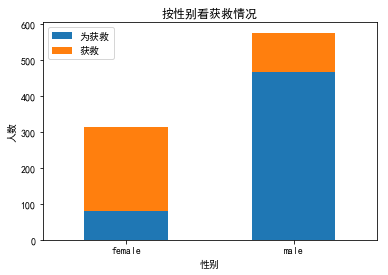

In [21]:
fig = plt.figure(figsize=(10,5))
fig.set(alpha=0.2)

Survived_0 = data_train.Sex[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Sex[data_train.Survived == 1].value_counts()

df = pd.DataFrame({'获救':Survived_1, '为获救':Survived_0})

df.plot(kind='bar', stacked=True)
plt.title("按性别看获救情况")
plt.xlabel("性别")
plt.ylabel("人数")
plt.xticks(rotation=360)

plt.show()

In [22]:
data_train.pivot_table(values='PassengerId',index='Survived',columns='Sex',aggfunc='count')

Sex,female,male
Survived,,
0,81,468
1,233,109


* 女性幸存率：74%  
  男性幸存率：19%

* 果然女性获救比例很高，符合 [小孩和女士先走]，性别无疑要作为重要特征加入模型之中。

#### <span style="color:green">登录港口(Embarked)与获救结果的关系<span>

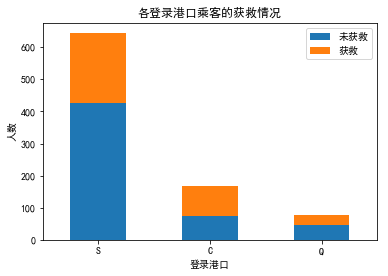

In [23]:
fig = plt.figure()
fig.set(alpha=0.2)

Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()

df = pd.DataFrame({'获救':Survived_1, '未获救':Survived_0})

df.plot(kind='bar', stacked=True)
plt.title("各登录港口乘客的获救情况")
plt.xlabel("登录港口")
plt.ylabel("人数")
plt.xticks(rotation=360)

plt.show()

In [24]:
data_train.pivot_table(values='PassengerId',index='Survived',columns='Embarked',aggfunc='count')

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


* C口岸登船的乘客幸存率更高

#### <span style="color:green">堂兄弟/妹(SibSp)、孩子/父母(Parch)人数与获救结果的关系<span>

In [25]:
gr1 = data_train.groupby(['SibSp', 'Survived']).count()['PassengerId']
df1 = pd.DataFrame(gr1)
print(df1)

print('\n\n' + '*'*30 + '\n')

gr2 = data_train.groupby(['Parch', 'Survived']).count()['PassengerId']
df2 = pd.DataFrame(gr2)
print(df2)

                PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7


******************************

                PassengerId
Parch Survived             
0     0                 445
      1                 233
1     0                  53
      1                  65
2     0                  40
      1                  40
3     0                   2
      1                   3
4     0                   4
5     0                   4
      1                   1
6     0                   1


* 看不出来规律，先作为备选特征，先放一放

#### Cabin只有204个登记记录，看看它的分布

In [26]:
data_train.Cabin.notnull().sum()

204

In [27]:
data_train.Cabin.value_counts()

G6                 4
C23 C25 C27        4
B96 B98            4
F33                3
D                  3
F2                 3
E101               3
C22 C26            3
F4                 2
C68                2
C123               2
C83                2
B57 B59 B63 B66    2
B77                2
E8                 2
C125               2
C52                2
E67                2
E121               2
B22                2
E33                2
D33                2
B51 B53 B55        2
F G73              2
B49                2
D17                2
D26                2
E25                2
C78                2
E24                2
                  ..
D11                1
E34                1
E49                1
B4                 1
C54                1
A32                1
C104               1
C62 C64            1
C99                1
B78                1
C110               1
B30                1
C32                1
F38                1
E77                1
E10                1
D49          

* Cabin作为类目型数据，如果直接按照类目特征处理的话，太分散了，估计每个因子化后的特征都拿不到什么权重。  
  加上空值又多，不如我们把Cabin缺失与否作为条件，看看有无Cabin信息和乘客等级/Survived的关联情况。  
  (但是这部分信息缺失可能并非没登记，或许只是没有保留下来而已)

In [28]:
data_train.Cabin.value_counts().values

array([4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

* 有记录的204个Cabin集中在1人间、2人间，而3人间和4人间的记录只有8个。  
  可是三等舱的乘客是最多的，理论上应该是3人间和4人间最多，是不是Cabin的空值集中在三等舱呢？

#### <span style="color:green">有无Cabin与乘客等级的关系<span>

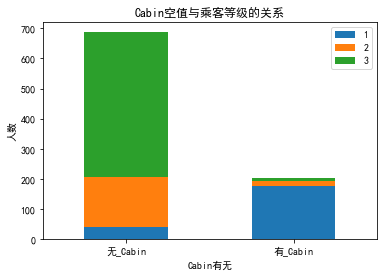

In [29]:
fig = plt.figure()
fig.set(alpha=0.2)

Pclass_cabin = data_train.Pclass[data_train.Cabin.notnull()].value_counts()
Pclass_nocabin = data_train.Pclass[data_train.Cabin.isnull()].value_counts()

df = pd.DataFrame({"有_Cabin":Pclass_cabin, "无_Cabin":Pclass_nocabin}).transpose()

df.plot(kind='bar', stacked=True)
plt.title("Cabin空值与乘客等级的关系")
plt.xlabel("Cabin有无")
plt.ylabel("人数")
plt.xticks(rotation=360)
plt.show()

* 和上面猜的一样，主要是三等舱的乘客没有Cabin记录，可能未登记，也可能登记了只是灾后丢失了而已

#### <span style="color:green">有无Cabin与获救结果的关系<span>

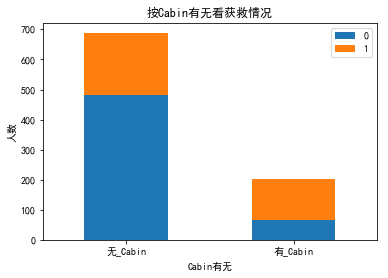

In [30]:
fig = plt.figure()
fig.set(alpha=0.2)

Survived_cabin = data_train.Survived[pd.notnull(data_train.Cabin)].value_counts()
Survived_nocabin = data_train.Survived[pd.isnull(data_train.Cabin)].value_counts()

df = pd.DataFrame({"有_Cabin":Survived_cabin, "无_Cabin":Survived_nocabin}).transpose()

df.plot(kind='bar', stacked=True)
plt.title("按Cabin有无看获救情况")
plt.xlabel("Cabin有无")
plt.ylabel("人数")
plt.xticks(rotation=360)

plt.show()

* 由于有Cabin记录的以一等舱乘客为主，所以获救率高也符合前面的数据

### <span style="color:orange">Data Processing and Feature Engineering<span>
#### 数据已经大体了解了，接下来该处理空值和数据类型，以及最重要的特征工程，为建模做准备

#### <span style="color:orange">补全缺失值<span>
#### <span style="color:green">Age：用RandomForest来拟合补全缺失值<span>

In [31]:
data_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [32]:
from sklearn.ensemble import RandomForestRegressor

def set_missing_ages(df): 
    
    #把已有的数值特征取出来放到RandomForestRegressor中
    age_df = df[['Age','Fare','Parch','SibSp','Pclass']]

     #乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()].as_matrix()
    unknown_age = age_df[age_df.Age.isnull()].as_matrix()

    #y即目标年龄
    y = known_age[:,0]

    #X即特征属性
    X = known_age[:,1:]

    #fit到RandomForestRegressor中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X,y)

    #用得到的模型预测未知年龄
    predictedAges = rfr.predict(unknown_age[:,1::])

    #用得到的预测结果填补原缺失数据
    df.loc[(df.Age.isnull()), 'Age'] = predictedAges

    return df, rfr


#### <span style="color:green">Cabin：按有无数据将这个特征处理成Yes和No两种类型，即变成类别特征<span>

In [33]:
def set_Cabin_type(df):
    df.loc[(df.Cabin.notnull()), 'Cabin'] = "Yes"
    df.loc[(df.Cabin.isnull()), 'Cabin'] = "No"

    return df

In [34]:
data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)

In [35]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,No,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Yes,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,No,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Yes,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,No,S


In [36]:
data_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64

* Age和Cabin的空值已经补全

#### <span style="color:orange">将类别特征因子化：One-Hot Encoding<span>
#### 逻辑回归建模时，需要输入数值型特征，像female和male这种类别特征都要转化成数值属性
#### <span style="color:green">需要处理的类别特征：Cabin/Embarked/Sex/Pclass<span>

In [37]:
dummies_Sex = pd.get_dummies(data_train.Sex, prefix='Sex')
dummies_Pclass = pd.get_dummies(data_train.Pclass, prefix='Pclass')
dummies_Cabin = pd.get_dummies(data_train.Cabin, prefix='Cabin')
dummies_Embarked = pd.get_dummies(data_train.Embarked, prefix='Embarked')

df = pd.concat([data_train, dummies_Sex, dummies_Pclass, dummies_Cabin, dummies_Embarked], axis=1)

df.drop(['Sex','Pclass','Cabin','Embarked','Name','Ticket'], axis=1, inplace=True)

In [38]:
df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,0,1,0,0,1,1,0,0,0,1
1,2,1,38.0,1,0,71.2833,1,0,1,0,0,0,1,1,0,0
2,3,1,26.0,0,0,7.9250,1,0,0,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,1,0,1,0,0,0,1,0,0,1
4,5,0,35.0,0,0,8.0500,0,1,0,0,1,1,0,0,0,1


#### <span style="color:orange">去均值和方差归一化：StandardScaler<span>
#### 将一些数据范围较大的特征标准化到(-1,1)之内，减缓模型收敛速度。
#### <span style="color:green">需要归一化的特征：Age/Fare<span>

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

age_scale_param = scaler.fit(df.Age.values.reshape(-1, 1))
df['Age_scaled'] = scaler.fit_transform(df.Age.values.reshape(-1, 1), age_scale_param)

fare_scale_param = scaler.fit(df.Fare.values.reshape(-1, 1))
df['Fare_scaled'] =scaler.fit_transform(df.Fare.values.reshape(-1, 1), fare_scale_param)

df.drop(['Age','Fare'], axis=1, inplace=True)

In [42]:
df.head()

,PassengerId,Survived,SibSp,Parch,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Age_scaled,Fare_scaled
0,1,0,1,0,0,1,0,0,1,1,0,0,0,1,-0.561380,-0.502445
1,2,1,1,0,1,0,1,0,0,0,1,1,0,0,0.613171,0.786845
2,3,1,0,0,1,0,0,0,1,1,0,0,0,1,-0.267742,-0.488854
3,4,1,1,0,1,0,1,0,0,0,1,0,0,1,0.392942,0.420730
4,5,0,0,0,0,1,0,0,1,1,0,0,0,1,0.392942,-0.486337


* 至此数据处理全部完成

### <span style="color:orange">逻辑回归建模：lr<span>

In [43]:
from sklearn.linear_model import LogisticRegression

train_df = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
train_np = train_df.as_matrix()      #转成numpy格式

#y即Survived，要预测的结果
y = train_np[:, 0]

#X即特征属性值
X = train_np[:, 1:]

lr = LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False)

### <span style="color:orange">test要和train做同样的数据处理<span>

In [92]:
data_test = pd.read_csv("test.csv")

In [93]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [94]:
data_test.shape

(418, 11)

In [95]:
data_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

#### <span style="color:green">填补空值：Fare (各等级船票价格差异很大，填补缺失值之前要看其对应的乘客等级)<span>

In [96]:
data_test.loc[(data_test.Fare.isnull()), :]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


* Fare只有一个空值，是一个三等舱乘客

In [97]:
P3_fmean = data_test.Fare[data_test.Pclass == 3].mean()
P3_fmean

12.459677880184334

* 三等舱的平均票价是12.46，我们把这个值填补到Fare的缺失值

In [98]:
data_test.loc[(data_test.Fare.isnull()), 'Fare'] = P3_fmean

#### <span style="color:green">填补空值：Age (前面已经保存了预测年龄的模型 "rfr")<span>

In [99]:
tmp_df = data_test[['Age','Fare','Parch','SibSp','Pclass']]
null_age = tmp_df[data_test.Age.isnull()].as_matrix()

X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[(data_test.Age.isnull()), 'Age'] = predictedAges

#### <span style="color:green">填补空值：Cabin (直接调用前面定义的方法set_Cabin_type())<span>

In [100]:
data_test = set_Cabin_type(data_test)

#### <span style="color:green">同样将类别特征One-Hot Encoding<span>

In [101]:
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix='Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix='Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix='Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix='Pclass')

df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)

#### <span style="color:green">将Age/Fare归一化 (前面定义了age_scale_param)<span>

In [102]:
df_test['Age_scaled'] = scaler.fit_transform(df_test['Age'].values.reshape(-1, 1), age_scale_param)
df_test['Fare_scaled'] = scaler.fit_transform(df_test['Fare'].values.reshape(-1, 1), age_scale_param)
df_test.drop(['Age','Fare'], axis=1, inplace=True)

In [103]:
df_test.head()

,PassengerId,SibSp,Parch,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,892,0,0,1,0,0,1,0,0,1,0,0,1,0.307521,-0.497311
1,893,1,0,1,0,0,0,1,1,0,0,0,1,1.256241,-0.512175
2,894,0,0,1,0,0,1,0,0,1,0,1,0,2.394706,-0.463999
3,895,0,0,1,0,0,0,1,0,1,0,0,1,-0.261711,-0.482373
4,896,1,1,1,0,0,0,1,1,0,0,0,1,-0.641199,-0.417392


* test数据集处理结束

### <span style="color:orange">用模型对test数据集做预测<span>

#### 调用训练好的模型 lr

In [104]:
test = df_test.filter(regex='Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*')
predictions = lr.predict(test)
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].as_matrix(), 'Survived':predictions.astype(np.int32)})

#### 保存预测结果

In [106]:
result.to_csv("lr_predictions.csv", index=False)

In [108]:
result.head(10)

,PassengerId,Survived
0,892,1
1,893,0
2,894,1
3,895,1
4,896,1
5,897,1
6,898,1
7,899,1
8,900,1
9,901,1


* OK，得到结果